In [7]:
import numpy as np
import matplotlib.pyplot as plt

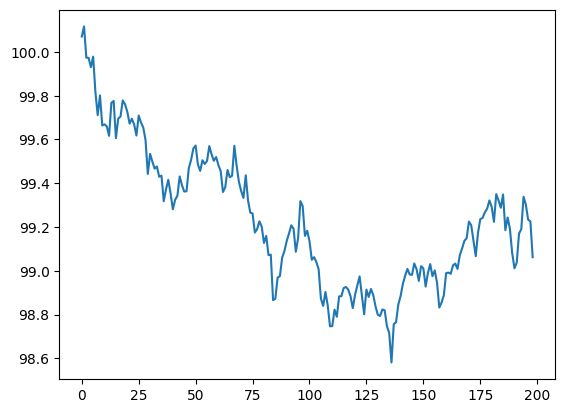

In [8]:
# Sample M paths of length T with N steps from a scaled brownian motion with 0 drift and variance sigma^2
def Sample_Brownian(S0,sigma,N,T,M):
    dt = T/N
    # np.random.normal takes stdev as parameter, hence sqrt(dt)
    St = sigma*np.random.normal(0,np.sqrt(dt), (M,N-1)).T
    St = S0+St.cumsum(axis=0)
    return St

plt.plot(Sample_Brownian(100,1,int(1/0.005),1,1))
plt.show()

In [58]:
def computeReservePrice(s,q,gamma,sigma,t,T):
    return s-q*gamma*(sigma**2)*(T-t)

def computeSpread(gamma,sigma,t,T,k):
    return gamma*(sigma**2)*(T-t)+2/gamma*np.log(1+gamma/k)

def computeRate(A,gamma,delta):
    return A*np.exp(-gamma*delta)

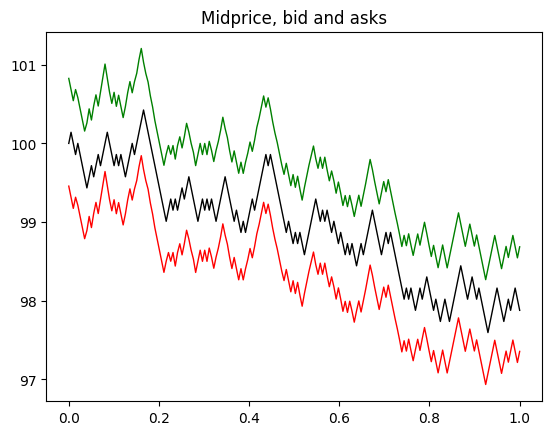

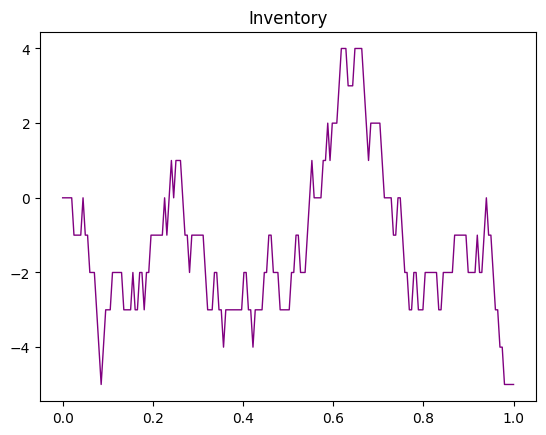

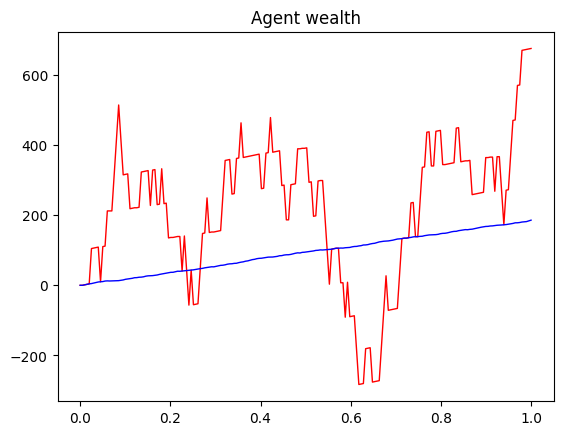

In [79]:
def simulateInventoryStrategy(plots=False):
    # initial stock price
    s=100
    # end time
    T=1
    # std dev of stock
    sigma=2
    # time step
    dt=0.005
    # initial inventory
    q=0
    # risk-aversion parameter
    gamma=0.01
    # 
    k=1.5
    # 
    A=140
    # initial wealth
    X=0
    # initial time
    t=0
    midprice = [s]
    bids = []
    asks = []
    wealth = [X]
    adj_wealth = [X]
    inventory = [q]

    while (t < T):
        if(t>0):
            midprice.append(s)
            wealth.append(X)
            adj_wealth.append(X+q*s)
            inventory.append(q)
            prob_a = computeRate(A,gamma,delta_a)*dt
            prob_b = computeRate(A,gamma,delta_b)*dt
            p = np.random.default_rng().uniform(0,1,None)
            if p <= prob_a:
                q = q-1
                X = X + (s+delta_a)
            p = np.random.default_rng().uniform(0,1,None)
            if p <= prob_b:
                q = q+1
                X = X - (s-delta_b)
        r = computeReservePrice(s,q,gamma,sigma,t,T)
        spread = computeSpread(gamma,sigma,t,T,k)
        delta_a = (spread/2+r)-s
        delta_b = s-(r-spread/2)
        p = np.random.default_rng().uniform(0,1,None)
        if p < 0.5:
            s+= sigma*np.sqrt(dt)
        else:
            s-= sigma*np.sqrt(dt)
        t+=dt
        bids.append(s-delta_b)
        asks.append(s+delta_a)
    if(plots):
        t = np.linspace(0,T,int(T/dt))
        plt.plot(t, midprice, 'black', linewidth=1.0)
        plt.plot(t, asks, 'green', linewidth=1.0)
        plt.plot(t, bids, 'red',linewidth=1.0)
        plt.title("Midprice, bid and asks")
        plt.show()
        plt.plot(t, inventory, 'purple', linewidth=1.0)
        plt.title("Inventory")
        plt.show()
        plt.title("Agent wealth")
        plt.plot(t, wealth, "red", linewidth=1.0)
        plt.plot(t, adj_wealth, "blue", linewidth=1.0)
        plt.show()
        
    return((X,q,s))

results = simulateInventoryStrategy(plots=True)

In [103]:
series = []
for i in range(1000):
    series.append(simulateInventoryStrategy())

186.4749125438297
13.483249911023862
140.09359049844215
258.9400636946625


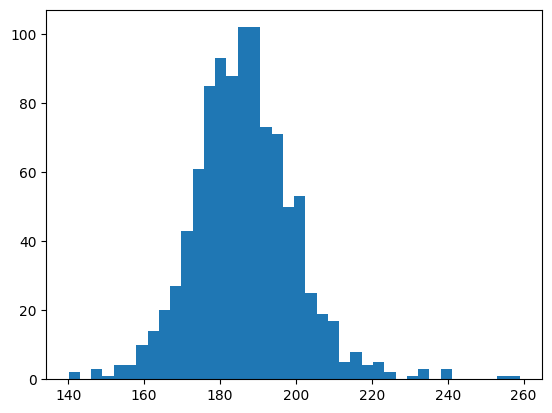

0.232
8.564471729184469


In [104]:
series = np.array(series)
final_inv = series[:,1]
adj_wealth = series[:,0]+final_inv*series[:,2]
print(np.mean(adj_wealth))
print(np.std(adj_wealth))
print(np.min(adj_wealth))
print(np.max(adj_wealth))
plt.hist(adj_wealth,bins=40)
plt.show()
print(np.mean(final_inv))
print(np.std(final_inv))

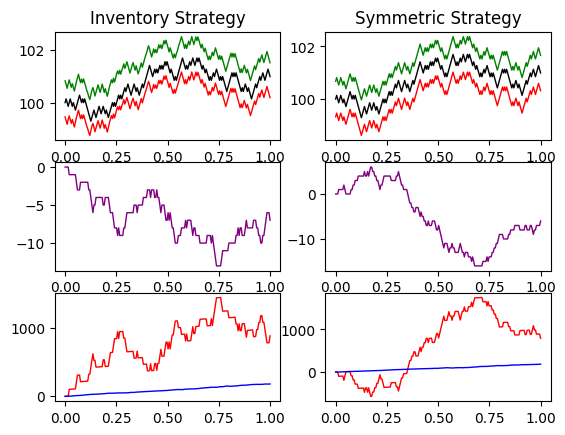

In [100]:
def simulateStrategy(plots=False):
    # initial stock price
    s=100
    # end time
    T=1
    # std dev of stock
    sigma=2
    # time step
    dt=0.005
    # initial inventory
    q=0
    # risk-aversion parameter
    gamma=0.01
    # 
    k=1.5
    # 
    A=140
    # initial wealth
    X=0
    # initial time
    t=0
    midprice = [s]
    inv_bids = []
    inv_asks = []
    inv_wealth = [X]
    inv_adj_wealth = [X]
    inv_inventory = [q]

    while (t < T):
        if(t>0):
            midprice.append(s)
            inv_wealth.append(X)
            inv_adj_wealth.append(X+q*s)
            inv_inventory.append(q)
            prob_a = computeRate(A,gamma,delta_a)*dt
            prob_b = computeRate(A,gamma,delta_b)*dt
            p = np.random.default_rng().uniform(0,1,None)
            if p <= prob_a:
                q = q-1
                X = X + (s+delta_a)
            p = np.random.default_rng().uniform(0,1,None)
            if p <= prob_b:
                q = q+1
                X = X - (s-delta_b)
        r = computeReservePrice(s,q,gamma,sigma,t,T)
        spread = computeSpread(gamma,sigma,t,T,k)
        delta_a = (spread/2+r)-s
        delta_b = s-(r-spread/2)
        p = np.random.default_rng().uniform(0,1,None)
        if p < 0.5:
            s += sigma*np.sqrt(dt)
        else:
            s -= sigma*np.sqrt(dt)
        t += dt
        inv_bids.append(s-delta_b)
        inv_asks.append(s+delta_a)
    inv_X = X
    #inv_wealth.append(X)
    #inv_adj_wealth.append(X+q*s)
    #midprice.append(s)
    inv_q = q
    mean_spread=np.mean(inv_asks)-np.mean(inv_bids)
    X = 0
    q = 0
    sym_bids=[]
    sym_asks=[]
    sym_wealth = [X]
    sym_adj_wealth = [X]
    sym_inventory = [q]
    for i in range(len(midprice)):
        if(i>0):
            sym_wealth.append(X)
            sym_adj_wealth.append(X+q*midprice[i])
            sym_inventory.append(q)
            prob_a = computeRate(A,gamma,delta_a)*dt
            prob_b = computeRate(A,gamma,delta_b)*dt
            p = np.random.default_rng().uniform(0,1,None)
            if p <= prob_a:
                q = q-1
                X = X + (midprice[i]+delta_a)
            p = np.random.default_rng().uniform(0,1,None)
            if p <= prob_b:
                q = q+1
                X = X - (midprice[i]-delta_b)
        delta_a = mean_spread/2
        delta_b = mean_spread/2
        p = np.random.default_rng().uniform(0,1,None)
        sym_bids.append(midprice[i]-delta_b)
        sym_asks.append(midprice[i]+delta_a)
    sym_X=X
    sym_q=q
    if(plots):
        t = np.linspace(0,T,int(T/dt))
        fig, axs = plt.subplots(3,2)
        axs[0,0].plot(t, midprice, 'black', linewidth=1.0)
        axs[0,0].plot(t, inv_asks, 'green', linewidth=1.0)
        axs[0,0].plot(t, inv_bids, 'red', linewidth=1.0)
        axs[0,0].set_title("Inventory Strategy")
        axs[1,0].plot(t, inv_inventory, 'purple', linewidth=1.0)
        #axs[1,0].set_title("Inventory Strategy Inventory")
        axs[2,0].plot(t, inv_wealth, "red", linewidth=1.0)
        axs[2,0].plot(t, inv_adj_wealth, "blue", linewidth=1.0)
        #axs[2,0].set_title("Inventory Strategy wealth")
        t = np.linspace(0,T,int(T/dt))
        axs[0,1].plot(t, midprice, 'black', linewidth=1.0)
        axs[0,1].plot(t, sym_asks, 'green', linewidth=1.0)
        axs[0,1].plot(t, sym_bids, 'red', linewidth=1.0)
        axs[0,1].set_title("Symmetric Strategy")
        axs[1,1].plot(t, sym_inventory, 'purple', linewidth=1.0)
        #axs[1,1].set_title("Symmetric Strategy Inventory")
        axs[2,1].plot(t, sym_wealth, "red", linewidth=1.0)
        axs[2,1].plot(t, sym_adj_wealth, "blue", linewidth=1.0)
        #axs[2,1].set_title("Symmetric Strategy Wealth")
    return((inv_X,inv_q,s,sym_X,sym_q))

results = simulateStrategy(plots=True)

In [101]:
series = []
for i in range(1000):
    series.append(simulateStrategy())

186.53403547483896
14.831747681115552
113.01573556000699
282.02925935876874


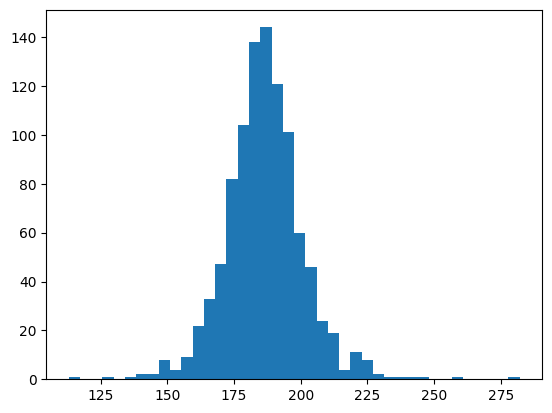

-0.351
9.059017551589136
186.36986643173825
14.445928226635077
98.43832433983698
259.3216340382237


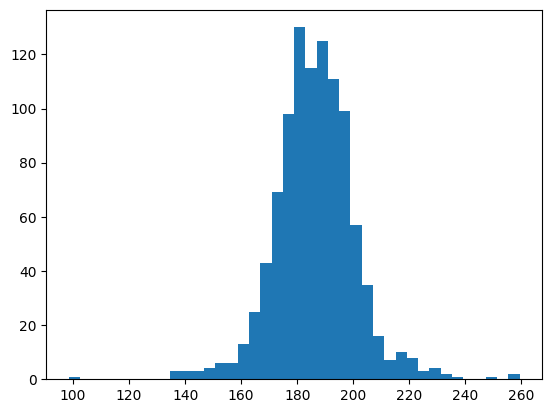

0.516
9.065745639493754


In [102]:
series = np.array(series)
inv_final_inv = series[:,1]
inv_adj_wealth = series[:,0]+inv_final_inv*series[:,2]
print(np.mean(inv_adj_wealth))
print(np.std(inv_adj_wealth))
print(np.min(inv_adj_wealth))
print(np.max(inv_adj_wealth))
plt.hist(inv_adj_wealth,bins=40)
plt.show()
print(np.mean(inv_final_inv))
print(np.std(inv_final_inv))

sym_final_inv = series[:,4]
sym_adj_wealth = series[:,3]+sym_final_inv*series[:,2]
print(np.mean(sym_adj_wealth))
print(np.std(sym_adj_wealth))
print(np.min(sym_adj_wealth))
print(np.max(sym_adj_wealth))
plt.hist(sym_adj_wealth,bins=40)
plt.show()
print(np.mean(sym_final_inv))
print(np.std(sym_final_inv))